In [35]:
import numpy as np
from numpy import pi as π
import scipy as sp
import scipy.integrate as integrate
import scipy.constants as consts
import matplotlib.pyplot as plt
import numba
import ipywidgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8,3)
TEST_CONVERGENCES = False
AU_TO_EV = 27.211324570273

### 2-Dimensional Case

Our central equation remains in the same form (now in 2D)
$$
\sum_\vec{G}V_{\vec{G}-\vec{G}'}\Psi_{\vec{k}-\vec{G}'} = \left(E - \frac{\hbar^2|\vec{k}-\vec{G}'|^2}{2m}\right)\Psi_{\vec{k}-\vec{G}}
$$

Where $\vec{k}=m_1a_1 + m_2a_2$ with $m_1,m_2\in\left[-\frac{\pi}{a},\frac{\pi}{a}\right]$ and $\vec{G}=n_1b_1+n_2b_2$ with $n_1,n_2\in\left[-\frac{2\pi}{a}n_c, \frac{2\pi}{a}n_c\right]$ and $n_c$ is the integer corresponding to the limit $G_c$.

We now calculate the Fourier components of the potential with
$$
V_\vec{G} = \frac{1}{A}\int d^2r \  e^{-i\vec{G}\cdot\vec{r}}\equiv\frac{1}{L^2}\int_0^L\int_0^Ldx_1dx_2 \ e^{-i(n_1b_1+n_2b_2)\cdot(x_1a_1+x_2a_2)} V(x_1,x_2)
$$

Which, by using the identity $a_i\cdot b_j=2\pi\delta_{ij}$, simplifies to
$$
V_\vec{G} = \frac{1}{L^2}\int_0^L\int_0^Ldx_1dx_2 \ e^{-i2\pi(n_1x_1 + n_2x_2)}V(x_1,x_2)
$$

In [229]:
def V_fourier2D(n,V,a=(1.0,1.0)):
    def integrand(x1,x2,n=n,V=V,a=a):
        n1,n2 = n
        a1,a2 = a
        func = np.exp(-1j*2*π*(n1*x1 + n2*x2)) * V(a1*x1,a2*x2)
        return np.real(func) # to get rid of complex warning
    VG,_ = integrate.dblquad(integrand,0,1,0,1)
    return VG

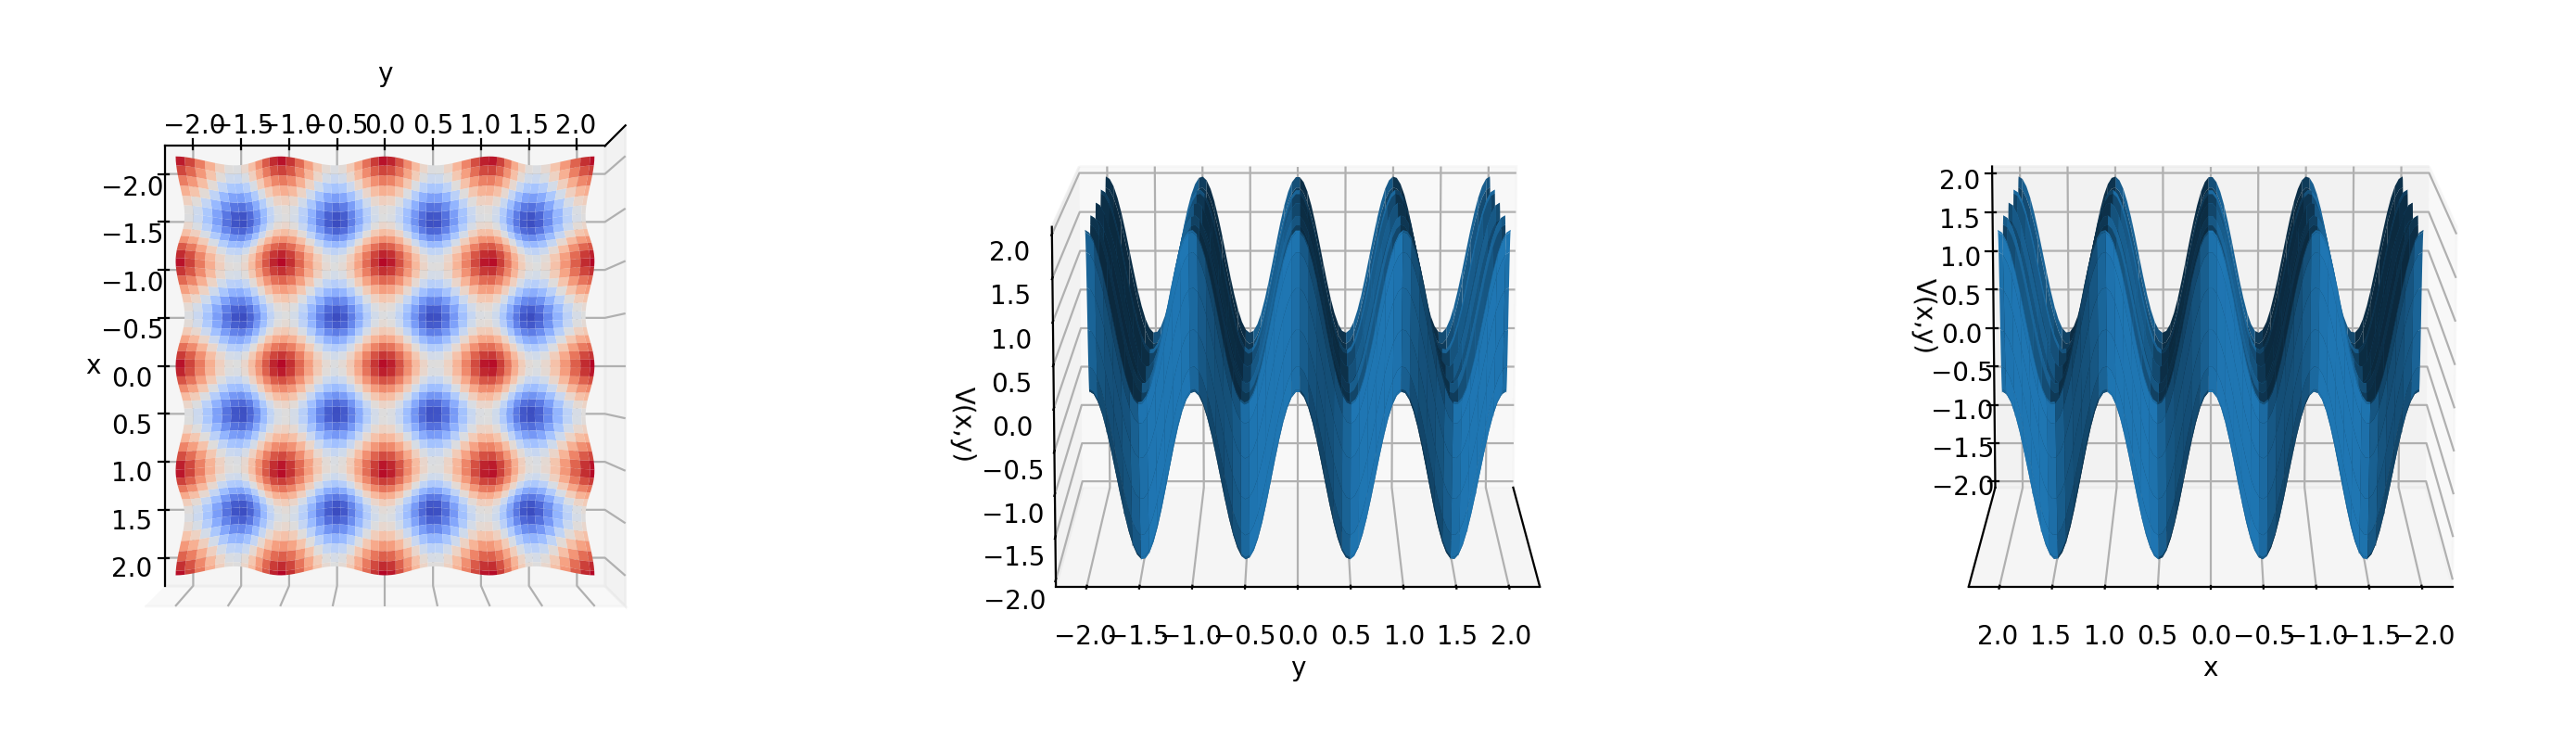

In [230]:
def V_cosine2D(x1,x2,a=(1.0,1.0),V10=1,V11=1):
    a1,a2 = a
    V1 = V10*np.cos(2*π*x1/a1) + V11*np.cos(2*π*x2/a2)
    V2 = 2*V10*V11*np.cos(2*π*x1/a1)*np.cos(2*π*x2/a2)
    return V1 #+ V2

a = (1,1)

X = Y = np.linspace(-2,2,100)
mX,mY = np.meshgrid(X,Y)
plt.figure(figsize=(18,5))

ax = plt.subplot(1,3,1, projection='3d')
V = V_cosine2D(mX,mY,a=a)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zticks([])
ax.plot_surface(mX,mY,V,cmap='coolwarm')
ax.view_init(90,0,0)

ax = plt.subplot(1,3,2, projection='3d')
V = V_cosine2D(mX,mY,a=a)
ax.set_ylabel('y')
ax.set_zlabel('V(x,y)')
plt.xticks([])
ax.plot_surface(mX,mY,V)
ax.view_init(10,0,0)

ax = plt.subplot(1,3,3, projection='3d')
V = V_cosine2D(mX,mY,a=a)
ax.set_xlabel('x')
ax.set_zlabel('V(x,y)')
plt.yticks([])
ax.plot_surface(mX,mY,V)
ax.view_init(10,90,0)

Since we will be calculating the Fourier components multiple times, it makes sense to store them in a cache. Instead of rebuilding the cache each time `construct_V_fourier2D` is run, we can store it globally.

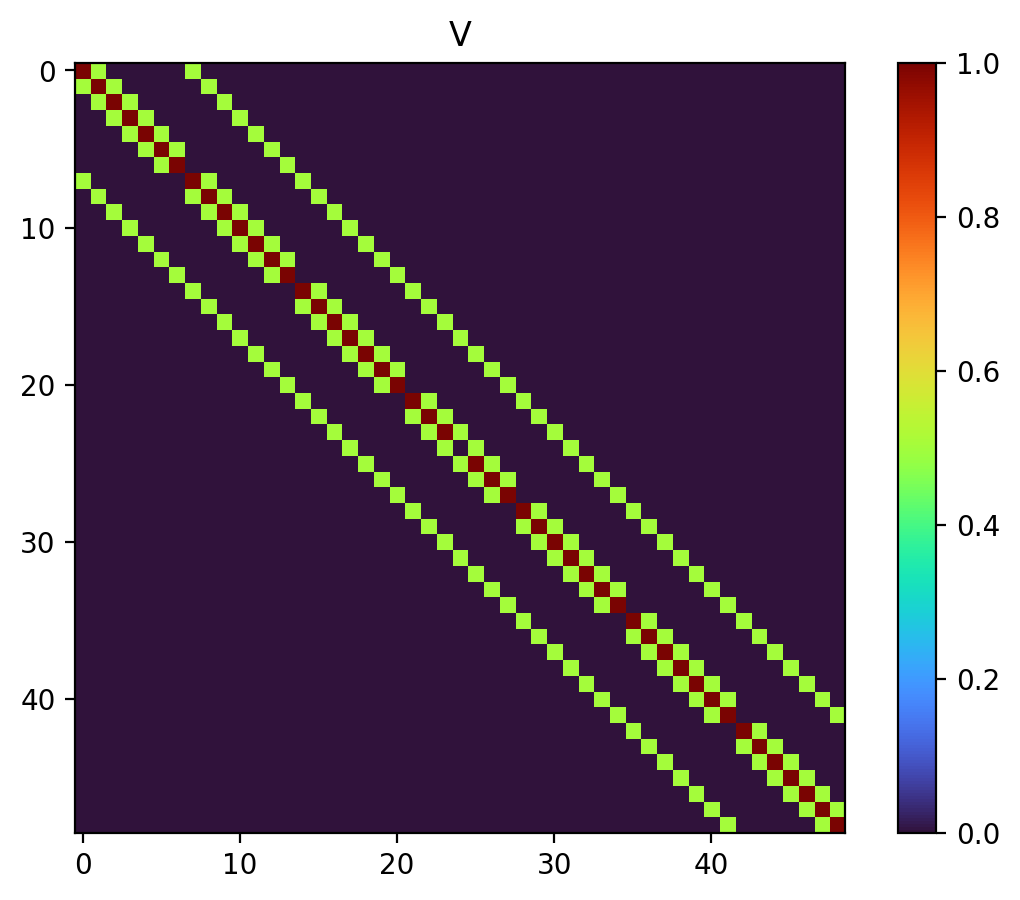

In [246]:
global V_cache
V_cache = {}
V_cache_func = V_cosine2D

def construct_V_fourier2D(k,                     # point at which to compute Σ(V_{G-G'} * Ψ_{k-G'})
                          nc,                    # cut-off/bound
                          V=V_cosine2D,          # potential function
                          ħ=1,m=1,a=(1,1),
                          opt=True,
                          fix_ky=None
                         ):
    a1,a2 = a
    G01 = 2*π/a1
    G02 = 2*π/a2
    N  = 2*nc + 1
    ns = np.empty((N**2,2))

    # generate all integers to be multiplied by G0
    for nx in range(N):
        for ny in range(N):
            i = nx*N + ny
            ns[i] = np.array([nx-nc, ny-nc])

    global V_cache,V_cache_func
    # if different potential is passed in (and thus cache is now invalid)
    if V != V_cache_func:
        print('resetting cache')
        V_cache = {}
        V_cache_func = V

    
    VG = np.zeros((N**2,N**2))
    for i,ni in enumerate(ns):
        k0x = k[0] - G01*ni[0]
        k0y = k[1] - G02*ni[1]
        if (fix_ky != None): k0y = fix_ky
        VG[i,i] += ħ**2 * (np.abs(k0x)**2 + np.abs(k0y)**2) /2/m
        for j,nj in enumerate(ns):
            nij = tuple(ni-nj)
            if nij not in V_cache:
                V_cache[nij] = V_fourier2D(ni-nj,V,a=a) #TODO: L=Na?
            VG[i,j] += V_cache[nij]
    return VG

nc = 3
a = (1,1)
VG  = construct_V_fourier2D((0,0),nc,a=a)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1).title.set_text('V')
plt.imshow(VG, cmap='turbo', vmax=1)
plt.colorbar();

In [247]:
def solve_tise2D(K,nc,V=V_cosine2D,a=1):
    Kx,Ky = K
    Nx,Ny = len(Kx),len(Ky)
    nE = (2*nc + 1)**2
    E = np.zeros((Nx,Ny,nE))
    Ψ = np.zeros((Nx,Ny,nE,nE))
    for ix,kx in enumerate(Kx):
        for iy,ky in enumerate(Ky):
            k = np.array([kx,ky])
            VG = construct_V_fourier2D(k,nc,V=V,a=a)
            E[ix,iy], Ψ[ix,iy] = sp.linalg.eigh(VG)
    return E,Ψ

nc = 3         # cutoff
N  = 50       # number of points on grid ("resolution")
Kx = np.linspace(-1,1,N+1) * π/a[0]
Ky = np.linspace(-1,1,N+1) * π/a[1]

E,Ψ = solve_tise2D((Kx,Ky),nc,a=a)

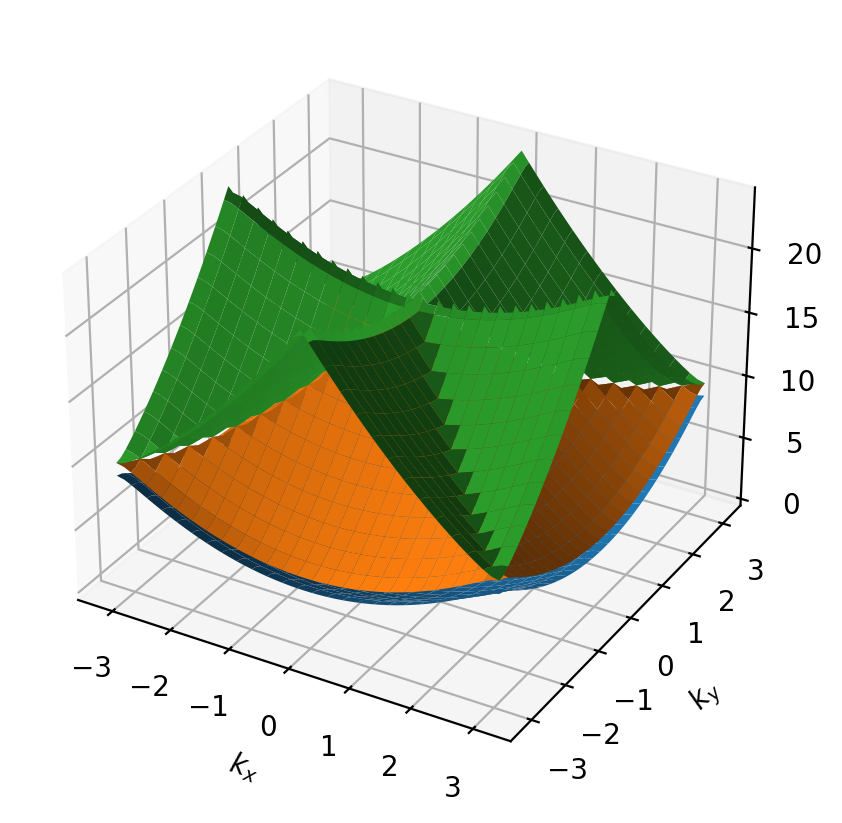

In [248]:
ax = plt.figure(figsize=(12,5)).add_subplot(projection='3d')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E$')

mKx,mKy = np.meshgrid(Kx,Ky)
for ε in range(0,3):
    ax.plot_surface(mKx,mKy,E[:,:,ε])

### Convergence Test

In [249]:
if TEST_CONVERGENCES:
    V = lambda x1,x2: V_cosine2D(x1,x2,V10=1,V11=1,a=a)
    
    k0 = π/a
    ncs = np.arange(nc0:= 2, nc1:= 15)
    nE = (2*nc0 + 1)**2
    
    E0,Ψ0 = solve_tise2D(([k0],[k0]),nc1,V=V,a=a)
    E0,Ψ0 = E0[0,0],Ψ0[0,0]
    
    E = np.empty((len(ncs),nE))
    Ψ = np.empty((len(ncs),nE))
    
    for i,nc in enumerate(ncs):
        ε,φ = solve_tise2D(([k0],[k0]),nc,V=V,a=a)
        ε,φ = ε[0,0],φ[0,0]
        E[i] = np.abs(ε[:nE] - E0[:nE])
        Ψ[i] = np.abs( np.abs(φ[:,:nE][1]) - np.abs(Ψ0[:,:nE][1]) )
        print(f'{i+1}/{len(ncs)}', end=(' | ' if i+1 != len(ncs) else ''))
    
    plt.figure(figsize=(16,5))
    ylbl = lambda lbl: rf'$\log({lbl} - {lbl}_{{n_c={nc1}}})$'
    
    plt.subplot(1,2,1)
    plt.xlabel(r'$n_c$')
    plt.ylabel(ylbl('E'))
    plt.title(f'Energies (first {nE})')
    plt.plot(ncs, np.log10(E));
    
    plt.subplot(1,2,2)
    plt.xlabel(r'$n_c$')
    plt.ylabel(ylbl('\psi'))
    plt.title(f'Eigenvectors (first {nE})')
    plt.plot(ncs, np.log10(Ψ));

In [this paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.063412) (Wu et al., 2017), a periodic potential $V(x,y)=-V_0\left[1-\cos(2\pi x/a_x)\right]\left[1-\cos(2\pi y/a_y)\right]$ with $V_0=0.5$ and $a_x=a_y=6$ (both in atomic units) was used.

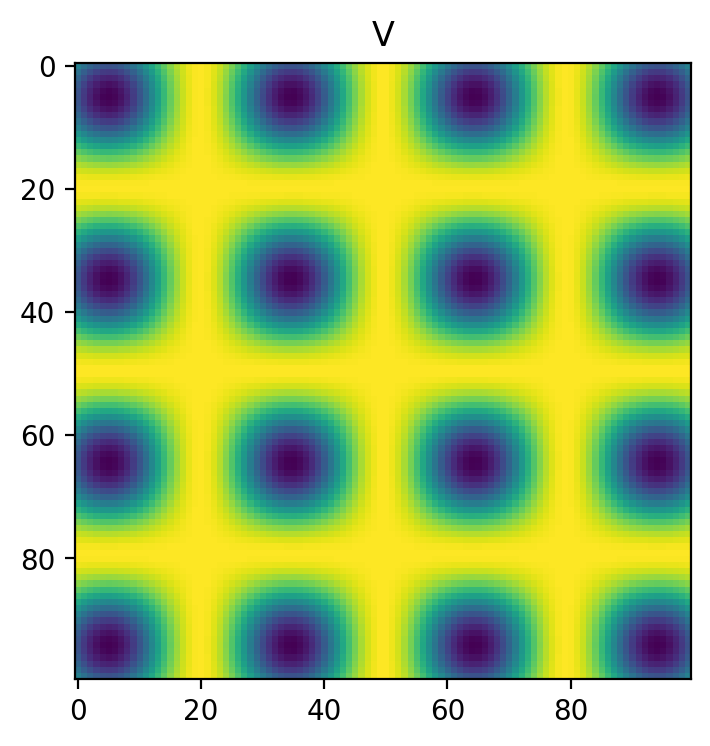

In [250]:
def V_Wu2D(x,y,a=(6,6),V0=0.5):
    ax,ay = a
    return -V0*(1 - np.cos(2*π*x/ax))*(1 - np.cos(2*π*y/ay))

X = Y = np.linspace(-10,10,100)
mX,mY = np.meshgrid(X,Y)

plt.figure(figsize=(4,4))
V = V_Wu2D(mX,mY)
plt.title('V')
plt.imshow(V);

In [252]:
a = (6,6)
N = 50
Kx = np.linspace(-1,1,N+1) * π/a[0]
Ky = np.linspace(-1,1,N+1) * π/a[1]
nc = 3
E,Ψ = solve_tise2D((Kx,Ky),nc,V_Wu2D,a=a)
E_eV = AU_TO_EV*E # au to eV

resetting cache


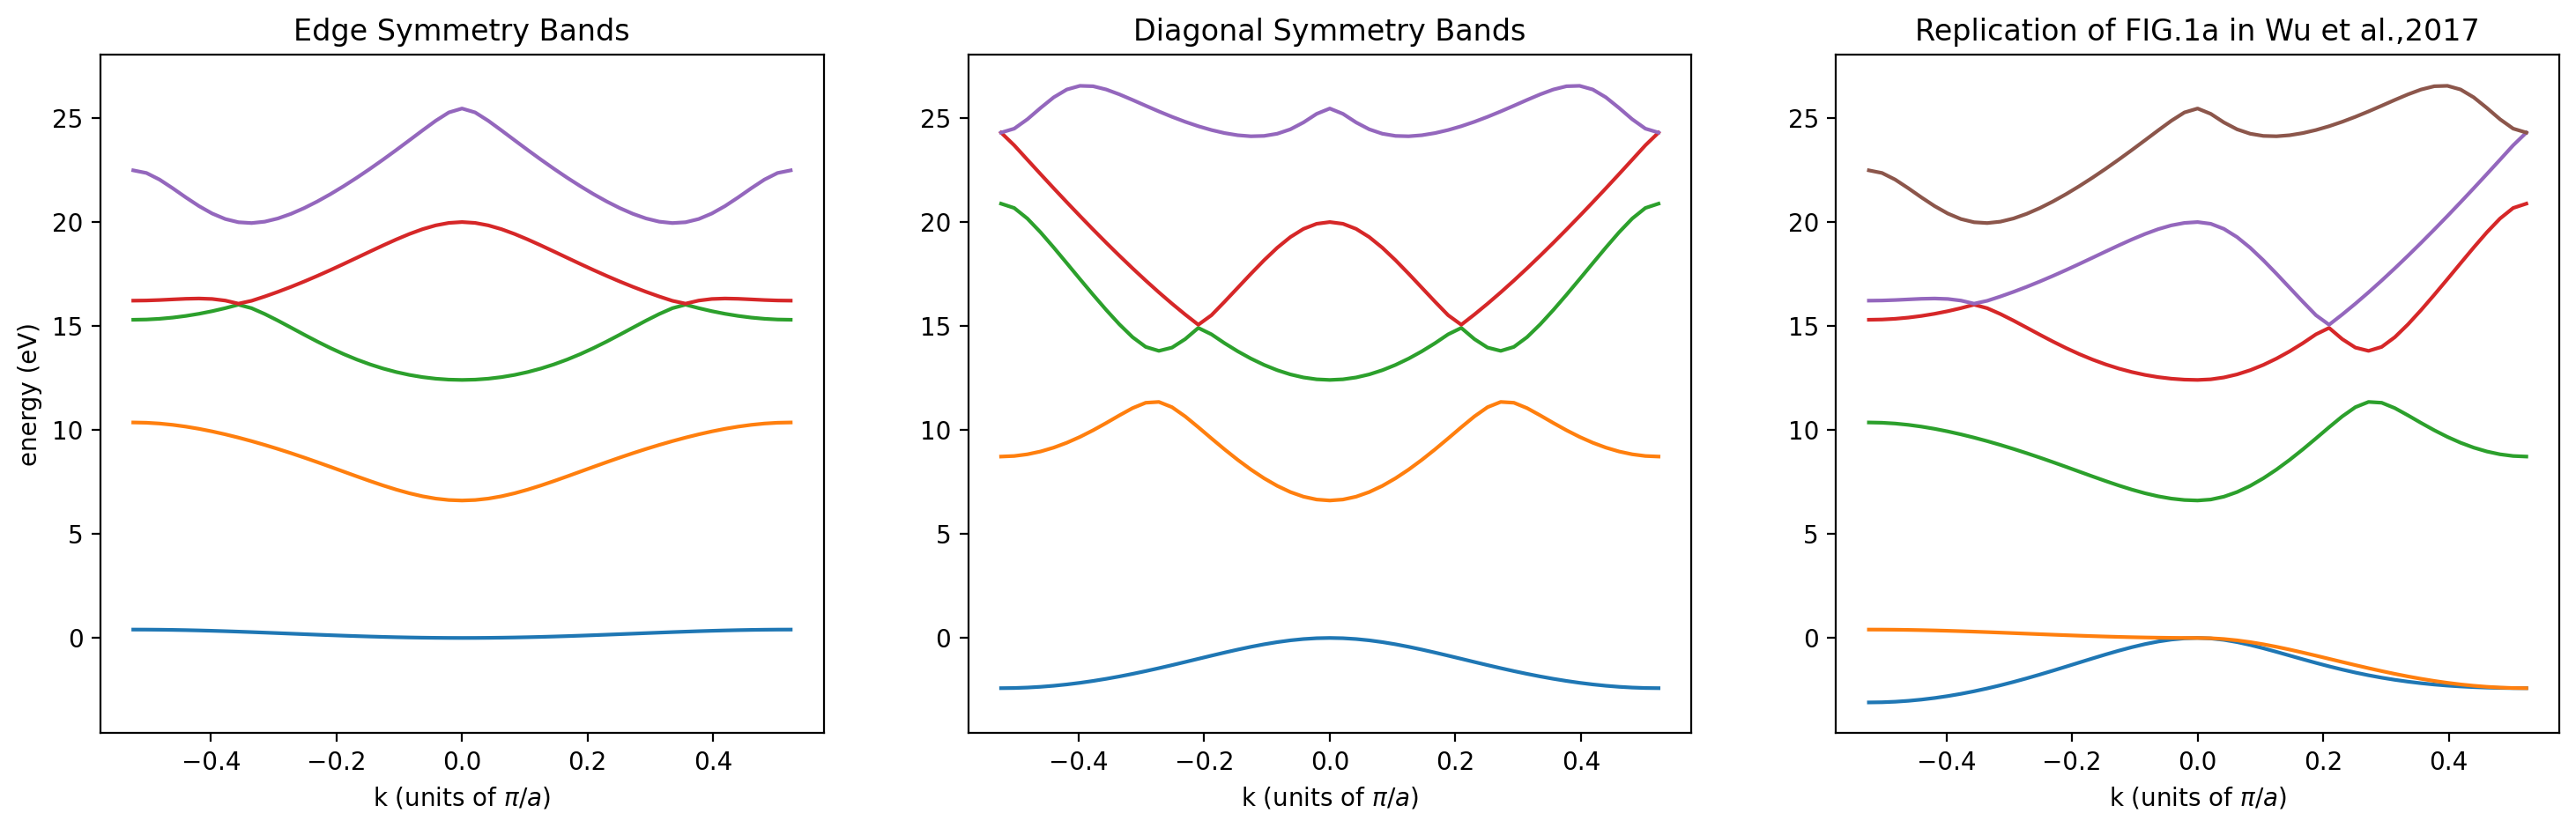

In [253]:
# E_eV ~ [kx index, ky index, E level]

def EXM(E,joined=False):
    nE = len(E)
    EX = E[:,nE//2] # all kx's where ky=0
    EM = np.array([E[r,r] for r in range(len(E))])
    if joined:
        split = np.array([(EX[i] if i < nE//2 else EM[i]) for i in range(nE)])
        return split
    else:
        return EX,EM

E_edges,E_diags = EXM(E_eV)
E_split = EXM(E_eV,joined=True)
norm_shift = E_split[N//2,1]

plt.figure(figsize=(18,5))

ax1 = plt.subplot(131)
#ax1.set_ylim(-10,27)
plt.title('Edge Symmetry Bands')
plt.xlabel(r'k (units of $\pi/a$)')
plt.ylabel('energy (eV)')
plt.plot(K,E_edges[:,2:7] - norm_shift)

plt.subplot(132, sharey=ax1)
plt.title('Diagonal Symmetry Bands')
plt.xlabel(r'k (units of $\pi/a$)')
plt.plot(K,E_diags[:,2:7] - norm_shift)

plt.subplot(133, sharey=ax1)
plt.title('Replication of FIG.1a in Wu et al.,2017')
plt.xlabel(r'k (units of $\pi/a$)')
plt.plot(K,E_split[:,1:7] - norm_shift);

### Field Coupling

In order to avoid confusion, from this point on I will denote energies as $\varepsilon$ instead of $E$, which will now instead represent electric fields.

Our TDSE is
$$
\boxed{i\hbar\dot{C}_{n\mathbf{k}}(t) = C_{n\mathbf{k}}(t)\varepsilon_{n\mathbf{k}} + \frac{e}{m}\sum_\mu A_\mu(t) \sum_{n'}C_{n'\mathbf{k}}(t)\left(\mathbf{p}_\mathbf{k}^{nn'}\right)_\mu}
$$

In [332]:
a = (6,6)
N = 50
Kx = np.linspace(-1,1,N+1) * π/a[0]
Ky = np.linspace(-1,1,N+1) * π/a[1]
nc = 5
ε,Ψ = solve_tise2D((Kx,Ky),nc,V_Wu2D,a=a)

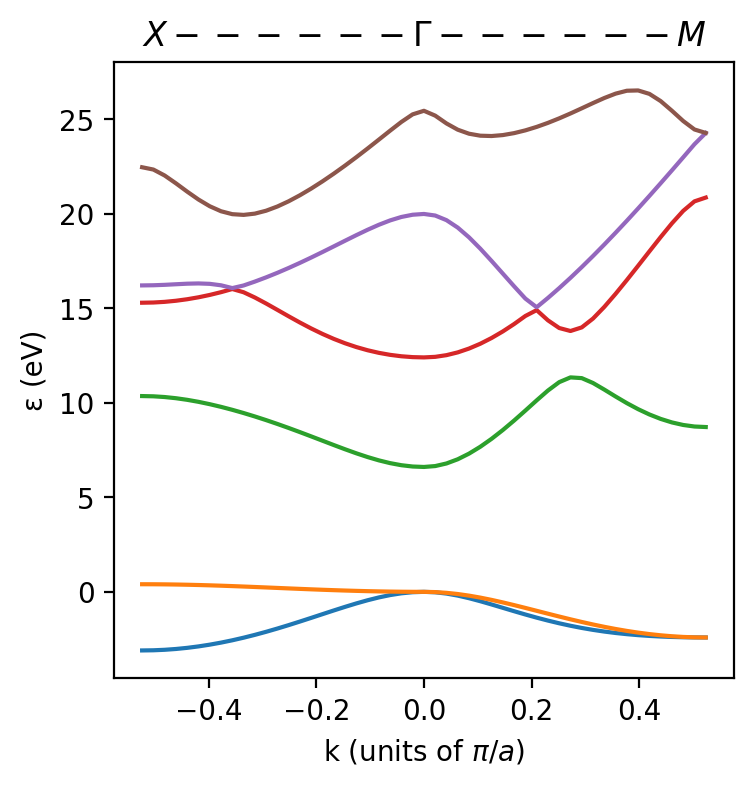

In [334]:
plt.figure(figsize=(4,4))

εX,εM = EXM(ε)

plt.title(r'$X------ \Gamma ------M$')
plt.xlabel(r'k (units of $\pi/a$)')
plt.ylabel('ε (eV)')
ε_split = EXM(AU_TO_EV*ε,True)
norm_shift = ε_split[N//2,1]
plt.plot(Kx,ε_split[:,1:7] - norm_shift);

Recall we calculate the momentum matrix with
$$
\left(\mathbf{p}^{nn'}_\mathbf{k}\right)_\mu = \hbar\sum_\mathbf{G}\psi_\mathbf{G}^{*n}\psi_\mathbf{G}^{n'}\left(k_\mu+G_\mu\right)
$$

In [335]:
@numba.njit
def construct_p2D(ik: tuple, # ikx,iky
                  K: tuple,  # Kx,Ky
                  ψ,
                  a: tuple,  # ax,ay
                  ħ=1):
    ikx,iky = ik
    kx,ky = K[0][ikx],K[1][iky]
    nE = ψ.shape[-1] # number of wave-fcns/energies
    N = int( np.sqrt(nE) )
    nc = N // 2
    Gs = np.empty((nE,2))
    ax,ay = a
    for nx in range(N):
        for ny in range(N):
            i = nx*N + ny
            Gs[i] = np.array([(nx-nc)/ax, (ny-nc)/ay]) * 2*π

    px = np.zeros((nE,nE),dtype=np.complex128)
    py = np.zeros_like(px)
        
    for iG,G in enumerate(Gs):
        Gx,Gy = G
        px += ħ * np.outer( np.conj(ψ[ikx,iky,iG]), ψ[ikx,iky,iG] ) * (kx - Gx)
        py += ħ * np.outer( np.conj(ψ[ikx,iky,iG]), ψ[ikx,iky,iG] ) * (ky - Gy)
        
    return px,py

In [336]:
@ipywidgets.interact(ik=(0,N))
def disp(ik=len(Kx)//2):
    plt.figure(figsize=(5,5))
    px,py = construct_p2D((ik,ik),(Kx,Ky),Ψ,a)
    plt.imshow(np.abs(px),vmax=1)
    plt.colorbar()
    return ik, f'k= {Kx[ik]/π*a[0]}π/a'

interactive(children=(IntSlider(value=25, description='ik', max=50), Output()), _dom_classes=('widget-interact…

In [337]:
unit_msg = u'''
From Wu et al. (2017), they calculate the harmonic spectra generated by a 1600-nm, 3.0 TW/cm\u00B2 laser pulse. Convert to atomic units:

1600-nm \u2192 f = c/(1.6e-6 meters) * (2.41884e-17 seconds) = 4.53219e-3 \u2192 ω\u2080 = 2π(4.53219e-3)

3.0 TW/cm\u00B2 \u2192 I=(1/2)cϵ\u2080|E\u2080|\u00B2 \u2192 E\u2080 = sqrt( 2*(3e16 W/m\u00B2)/(c*ϵ\u2080) ) / (5.14221e11 V/m) = 9.24573e-3
'''
print(unit_msg)
A0_Wu2D = 9.24573e-3   # From I=(1/2)cϵₒEₒ^2
ω0_Wu2D = 2*π*(4.53219e-3) # From 1600nm laser wavelength and f=c/λ
ω_Wu2D = ω0_Wu2D / 22


From Wu et al. (2017), they calculate the harmonic spectra generated by a 1600-nm, 3.0 TW/cm² laser pulse. Convert to atomic units:

1600-nm → f = c/(1.6e-6 meters) * (2.41884e-17 seconds) = 4.53219e-3 → ω₀ = 2π(4.53219e-3)

3.0 TW/cm² → I=(1/2)cϵ₀|E₀|² → E₀ = sqrt( 2*(3e16 W/m²)/(c*ϵ₀) ) / (5.14221e11 V/m) = 9.24573e-3



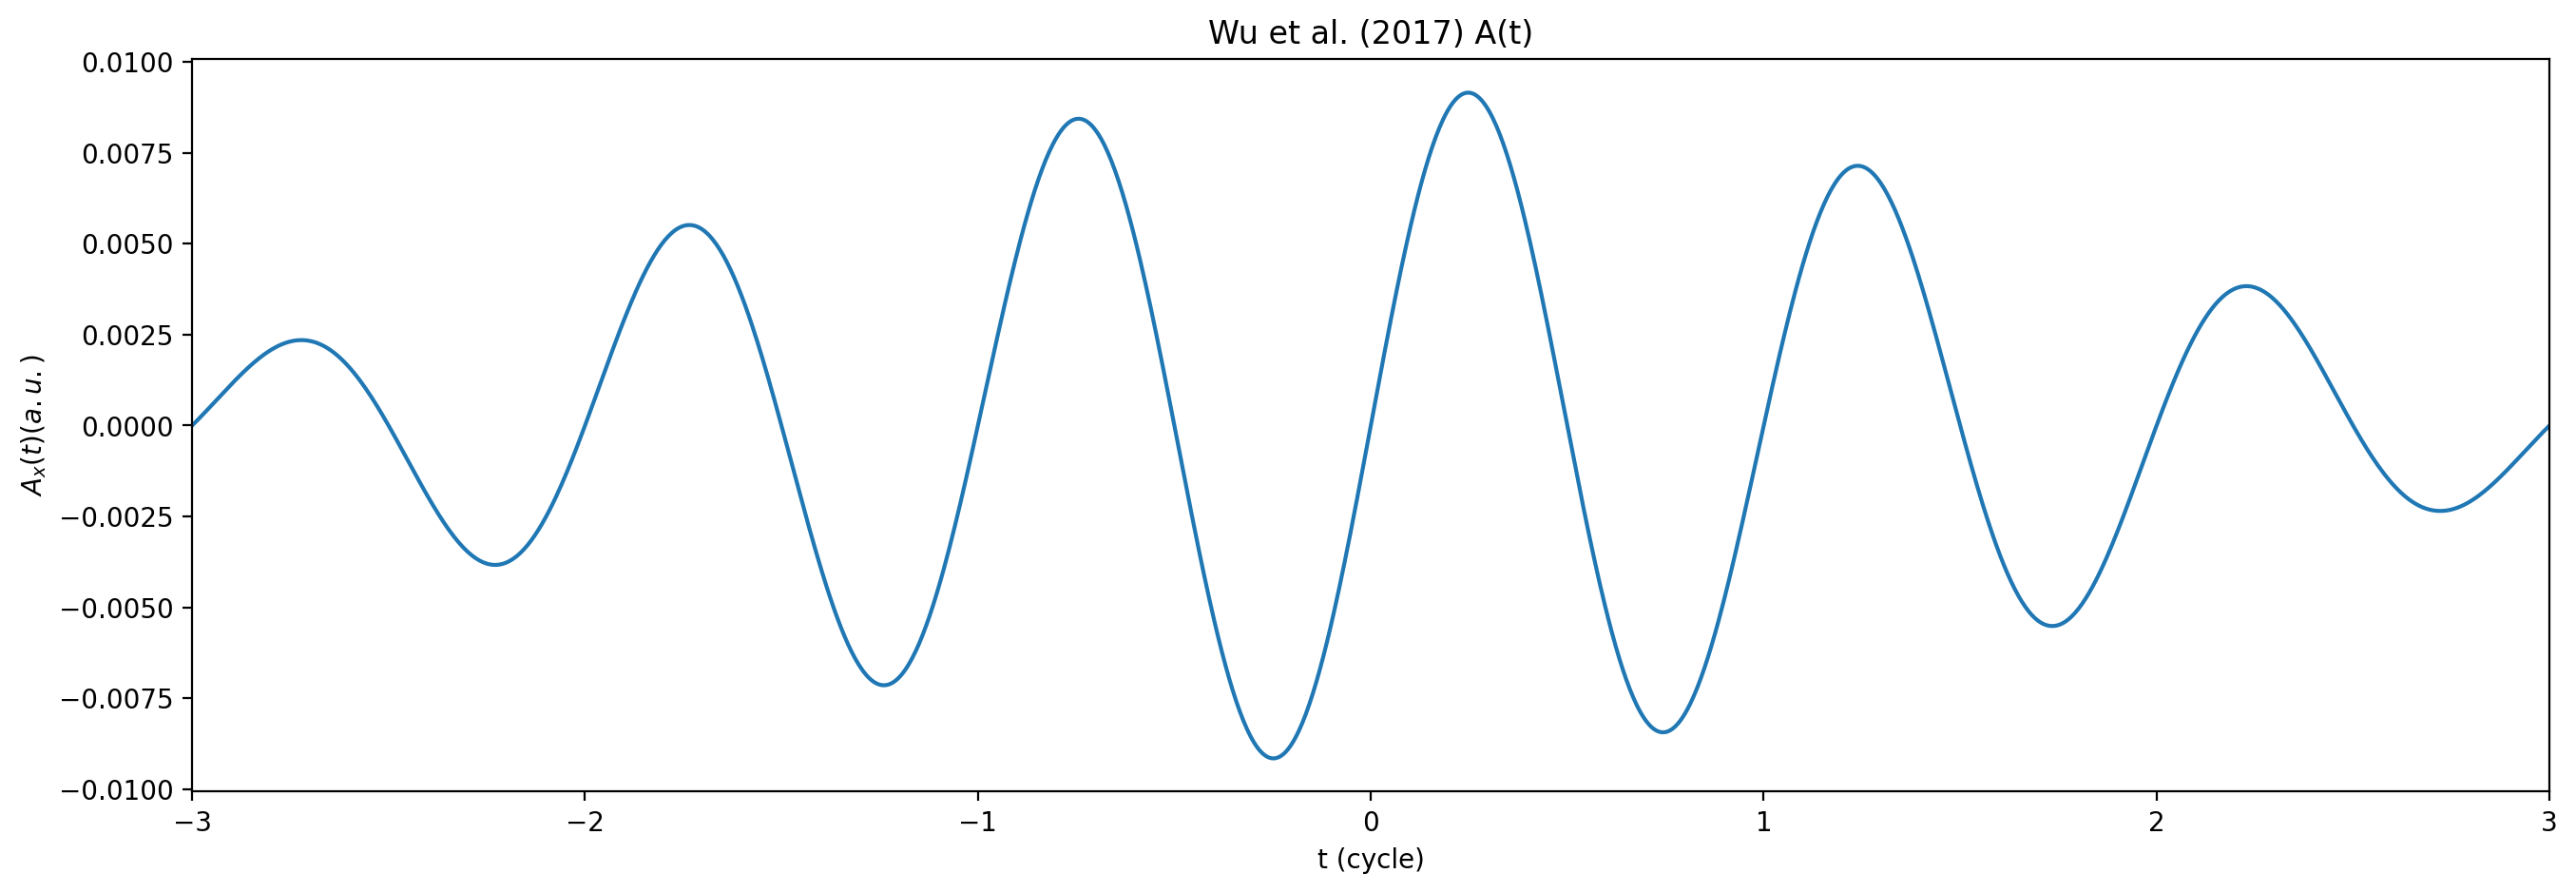

In [350]:
@numba.njit
def A_Wu2D(t,ω0=ω0_Wu2D,ω=ω_Wu2D,A0=A0_Wu2D):
    Ax = A0 * np.cos(ω*t)**4 * np.sin(ω0*t)
    Ay = 0.0*t
    return Ax,Ay

δt = 1
t0,t1 = -π/2/ω_Wu2D, π/2/ω_Wu2D
T = np.arange(t0,t1+δt,δt)

plt.figure(figsize=(16,5))

plt.xlim(-3,3)
plt.title('Wu et al. (2017) A(t)')
plt.xlabel('t (cycle)')
plt.ylabel(r'$A_x(t) (a.u.)$')
plt.plot(T*ω0_Wu2D/2/π,A_Wu2D(T)[0],label='A(t)');

In [351]:
@numba.njit
def tdse2D(ti,C,ε_nk,p,e,m):
    px,py = p
    Ax,Ay = A_Wu2D(ti)
    return -1.0j*(ε_nk*C + e/m*(Ax*px + Ay*py)@C)

def solve_tdse2D(t,δt,
                 C0,
                 ik: tuple, # ikx,iky
                 K:  tuple, # Kx,Ky
                 ε,Ψ,
                 a,
                 e=1,m=1):
    t0,t1 = (t[0],t[1]) if isinstance(t,list) else (0,t)
    p = construct_p2D(ik,K,Ψ,a)
    T = np.arange(t0,t1,δt)
    C0 = np.array(C0, dtype=np.complex128)
    soln = integrate.solve_ivp(tdse2D, [t0,t1], C0, t_eval=T, args=(ε[ik],p,e,m), 
                               method='DOP853', rtol=1e-10, atol=1e-10)
    return soln.t, soln.y

In [352]:
%%time
ik = len(K)//2
print(f'k = {K[ik]*a[0]/π}π/a')
C0 = np.zeros(Ψ.shape[-1])
C0[n := 1] = 1

T,C = solve_tdse2D([t0,t1],δt,C0,(ik,ik),(Kx,Ky),ε,Ψ,a)

k = 0.0π/a
CPU times: user 1min 13s, sys: 627 ms, total: 1min 13s
Wall time: 9.9 s


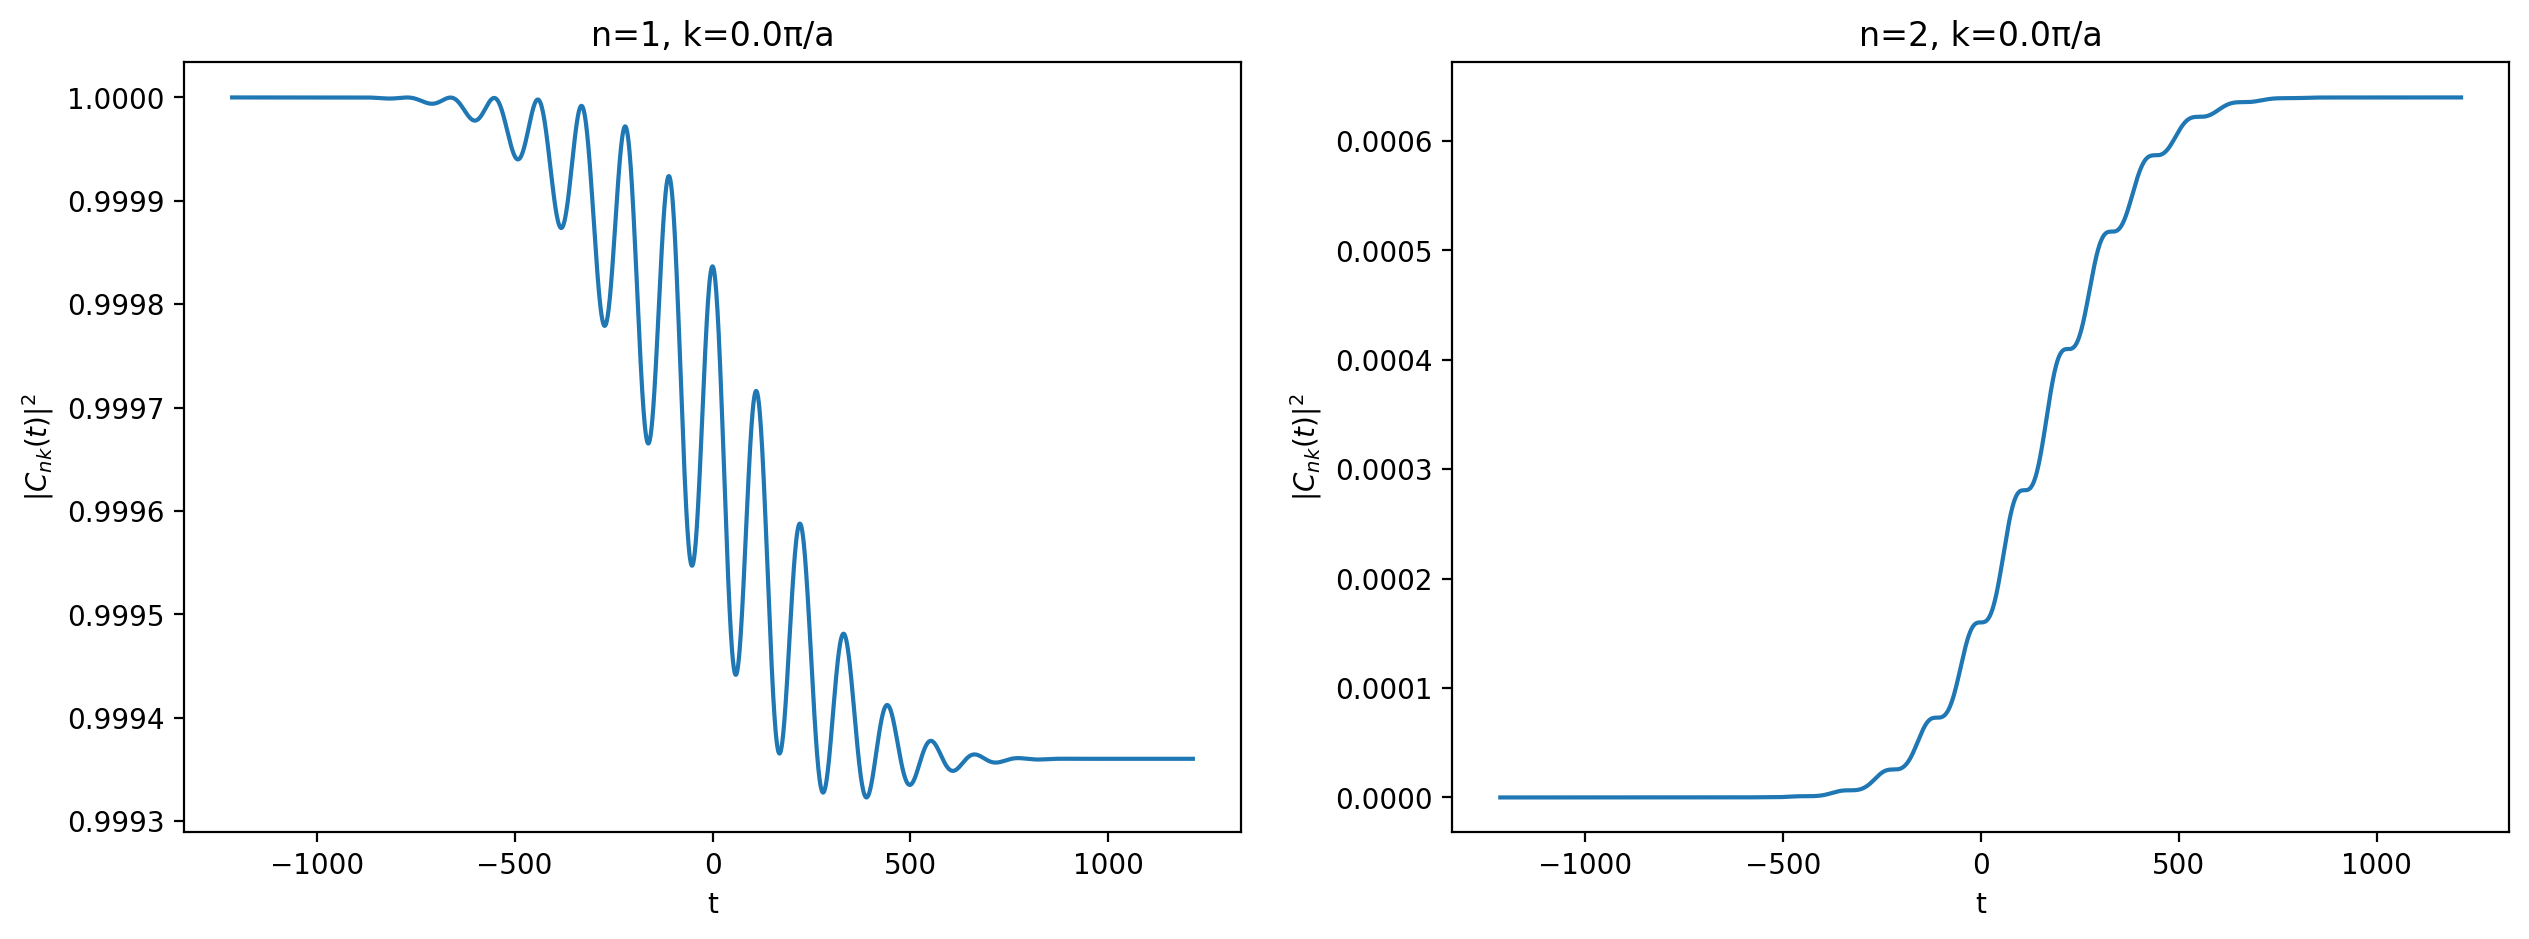

In [353]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title(f'n={n}, k={K[ik]*a[0]/π}π/a')
plt.xlabel('t')
plt.ylabel(r'$|C_{nk}(t)|^2$')
plt.plot(T,np.abs(C[n])**2)

plt.subplot(1,2,2)
plt.title(f'n={n+1}, k={K[ik]*a[0]/π}π/a')
plt.xlabel('t')
plt.ylabel(r'$|C_{nk}(t)|^2$')
plt.plot(T,np.abs(C[n+1])**2);

Recall that we are interested in computing
$$
I_\text{HHG} = \left|\left(j_\mathbf{k}(\omega)\right)_\mu\right|^2
$$

where
$$
\left(j_{\mathbf{k}}(t)\right)_\mu = -\frac{e}{m}\left[\text{Re}\left(\sum_n\sum_{n'}C^*_{n\mathbf{k}}(t)C_{n'\mathbf{k}}(t)\left(p_\mathbf{k}^{nn'}\right)_\mu\right) + eA_\mu(t)\right]
$$

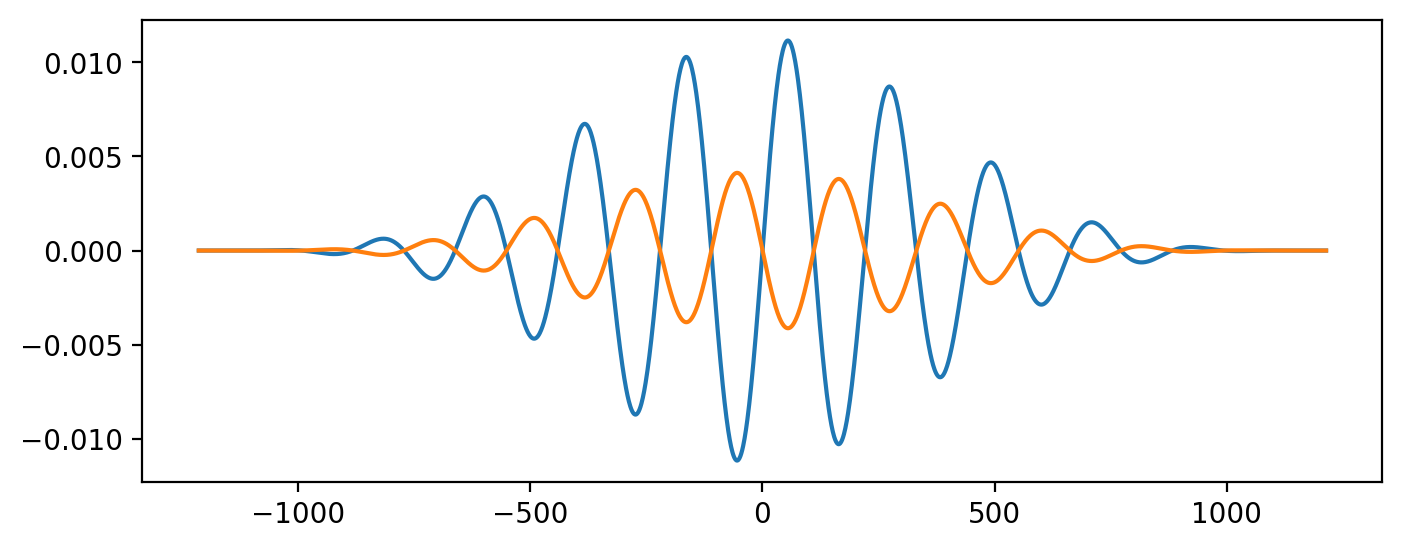

In [354]:
@numba.njit
def construct_j2D(T,C,ik,K,Ψ,A,a,e=1,m=1):
    px,py = construct_p2D(ik,K,Ψ,a)
    Ax,Ay = A(T)
    nE,nT = C.shape
    ccp_x = np.zeros(nT, dtype=np.complex128)
    ccp_y = np.zeros_like(ccp_x)
    for n in range(nE):
        ccp_x += np.conj(C[n]) * (C.T @ px[n])
        ccp_y += np.conj(C[n]) * (C.T @ py[n])
        
    jx = -e/m * (np.real(ccp_x) + e*Ax)
    jy = -e/m * (np.real(ccp_y) + e*Ay)
    return jx,jy   

Jx,Jy = construct_j2D(T,C,(ik,ik),(Kx,Ky),Ψ,A_Wu2D,a)
plt.plot(T,Jx);
plt.plot(T,Jy);

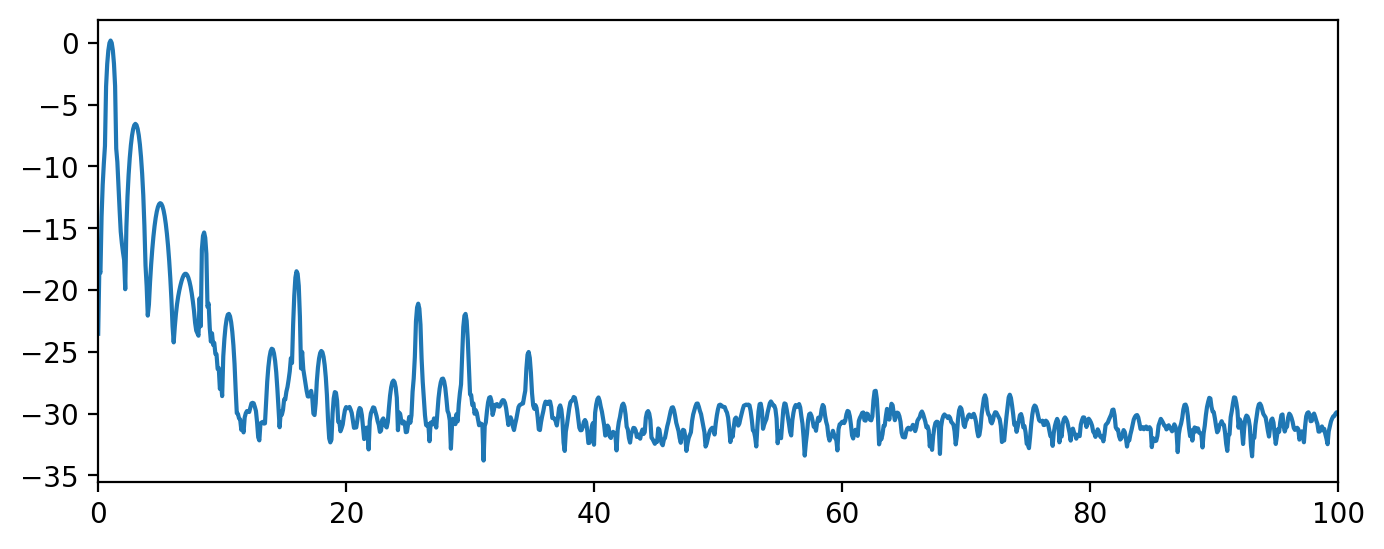

In [355]:
def I_HHG(J,δt,ω=ω_Wu2D):
    Nt = len(J)
    Jω = np.fft.fft(J*np.cos(T*ω)**4)
    Ω  = np.fft.fftfreq(Nt,d=δt)*2*π
    Ω, Jω = Ω[:Nt//2], Jω[:Nt//2]
    return Ω, np.abs( Jω/np.max(Jω) )**2

Ωx,Ix = I_HHG(Jx,δt)
Ωy,Iy = I_HHG(Jy,δt)

plt.xlim(0,100)
plt.plot(Ωx/ω0_Wu2D, np.log10(Ix));